In [9]:
from imp import reload

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import networkx as nx
import seaborn as sns

from lib import IO
from lib import Loader
from lib import graph
from lib import pt_utils

plt.rcParams['figure.dpi'] = 100
serif = plt.rcParams['font.sans-serif']
# plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
# plt.rcParams['font.sans-serif'] = serif

reload(Loader)
reload(graph)
reload(IO)
bjh = Loader.BJLoader('highway')
bjm = Loader.BJLoader('metro')

In [ ]:
# od asfreq code
names = od.index.names
od = od.groupby([pd.Grouper(level=names[0], freq=freq), names[1], names[2]]).sum()

In [10]:
od_highway = bjh.load_ts_od()
od_metro = bjm.load_ts_od()

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


## OD sum

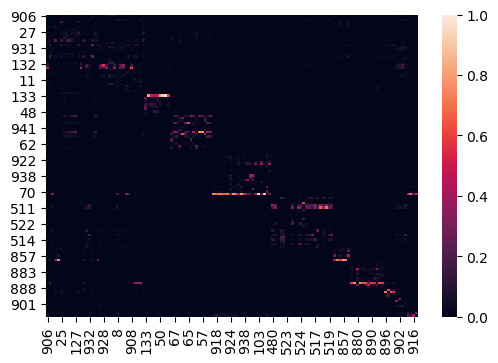

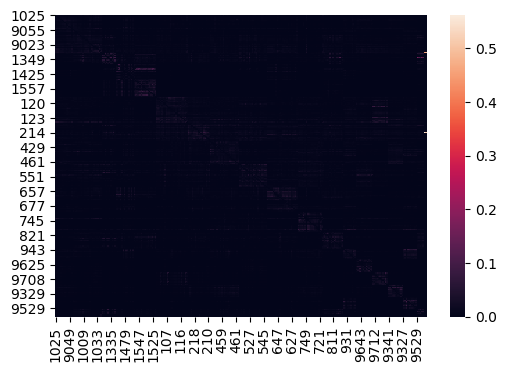

In [6]:
for loader in [bjh, bjm]:
    od = loader.load_od()
    plt.figure()
    od = od / (od.sum() + 1e-8)
    sns.heatmap(od)
    plt.show()

In [6]:
od_highway

EntryTime            Entry  Exit
2013-07-01 00:00:00  11     21      1
                     14     887     1
                     22     99      1
                     27     132     1
                     28     942     1
                     48     52      1
                     49     133     2
                     50     133     1
                     51     49      1
                            53      1
                     54     51      1
                            133     1
                     56     57      4
                            59      2
                            63      1
                            942     2
                     59     56      2
                            58      1
                     60     66      1
                     63     58      1
                     68     11      1
                            70      4
                            103     2
                            913     4
                            916     1
                 